## Model with polynomial features

In [1]:
#pip install scikit-learn==0.23.2

In [197]:
#import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [131]:
#Columns to be considered

num_col = {'Bsmt Cond',
 'Bsmt Exposure',
 'Bsmt Qual',
 'BsmtFin SF 1',
 'Exter Cond',
 'Exter Qual',
 'Fireplaces',
 'Full Bath',
 'Garage Cars',
 'Garage Cond',
 'Garage Qual',
 'Gr Liv Area',
 'Heating QC',
 'Kitchen Qual',
 'Mas Vnr Area',
 'Open Porch SF',
 'Overall Qual',
 'Total_area',
 'Wood Deck SF',
 'age_since_built',
 'lot_frontage_imputed'}

cat_to_num = {'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
    'Bsmt Exposure', 'Heating QC',
    'Kitchen Qual', 'Garage Qual', 'Garage Cond'}
     


cat_col = {'Bldg Type',
 'Foundation',
 'Street',
 'Central Air',
 'Electrical',
 'MS Zoning',
 'Land Contour',
 'Mas Vnr Type',
 'Heating',
 'Paved Drive',
 'Neighborhood'
          }

In [132]:
def cleaning_data(df):
    
    # 1. Drop most missing columns 
    df = df.drop(
    columns=['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'])

    # 2. Impute lot frontage
    from sklearn.linear_model import LinearRegression
    X_lot = df[df['Lot Frontage'] > 0][['1st Flr SF','Lot Area']]
    y_lot = df[df['Lot Frontage'] > 0]['Lot Frontage']
    lot_model = LinearRegression()
    lot_model.fit(X_lot,y_lot)
    
    lot_frontage_imputed = []
    for i in range(len(df)):
        if df.loc[i,'Lot Frontage'] > 0:
            lot_frontage_imputed.append(df.loc[i,'Lot Frontage'])
        else:
            lot_frontage_imputed.append(lot_model.predict([df.loc[i,['1st Flr SF','Lot Area']]])[0])

    df['lot_frontage_imputed'] = lot_frontage_imputed
    df = df.drop(columns = ['Lot Frontage'])
    
    #Garage Imputation

    df['Garage Yr Blt'] = df['Garage Yr Blt'].map(lambda x: x if x > 0 else 0)
    df['Garage Finish'] = df['Garage Finish'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Qual'] = df['Garage Qual'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Cond'] = df['Garage Cond'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Type'] = df['Garage Type'].map(lambda x: x if type(x) == str else 'NO')
    
    #Basement imputation
    df['Bsmt Exposure'] = df['Bsmt Exposure'].map(lambda x: x if type(x) == str else 'NO')
    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map(lambda x: x if type(x) == str else 'NO')
    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map(lambda x: x if type(x) == str else 'NO')
    df['Bsmt Cond'] = df['Bsmt Cond'].map(lambda x: x if type(x) == str else 'NO')
    df['Bsmt Qual'] = df['Bsmt Qual'].map(lambda x: x if type(x) == str else 'NO')
    
    #Mansory type and area
    df['Mas Vnr Type'] = df['Mas Vnr Type'].map(lambda x: x if type(x) == str else 'NO')
    df['Mas Vnr Area'] = df['Mas Vnr Area'].map(lambda x: x if x > 0 else 0)
    
    #Electrical Imputation
    df['Electrical'] = df['Electrical'].map(lambda x: x if type(x) == str else df['Electrical'].mode()[0])
    #Drop other observation containing Null
    df = df.dropna()
    
    return df

#Feature Engieering Function
def feat_eng(df):
    df['age_since_built'] = df['Yr Sold'] - df['Year Built']
    df['Total_area'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']
    return df
#Converted OrdiNal Categorical columns to Numerical 
def cat2num(df):
    for col in cat_to_num:
        df[col] = df[col].map(to_num)
    return df

#Conversion function
def to_num(val):
    if val == 'Ex':
        return 5
    elif val == 'Gd':
        return 4
    elif val == 'TA' or val == 'Av':
        return 3
    elif val == 'Fa' or val == 'Mn':
        return 2
    elif val == 'Po' or val == 'No':
        return 1
    elif val == 'NO':
        return 0



In [198]:
def prep_poly(df, train_df):
    """
    df = DataFrame to be transformed
    train_df = cleaned training set
    """

    #OneHotEncoding
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(train_df[cat_col])
    df_encode = pd.DataFrame(encoder.transform(df[cat_col]),
                             columns=encoder.get_feature_names(
                                 df[cat_col].columns),
                             index=df.index)

    train_df_encode = pd.DataFrame(encoder.transform(train_df[cat_col]),
                                   columns=encoder.get_feature_names(
                                       train_df[cat_col].columns),
                                   index=train_df.index)

    #Applying Polynomial Features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    df_withpoly = pd.DataFrame(
        poly.fit_transform(df[num_col]),
        columns=poly.get_feature_names(input_features=df[num_col].columns),
        index=df.index)

    train_df_withpoly = pd.DataFrame(
        poly.fit_transform(train_df[num_col]),
        columns=poly.get_feature_names(
            input_features=train_df[num_col].columns),
        index=train_df.index)

    #Merge with numerical attribute
    X_new = pd.concat([df_withpoly, df_encode], axis=1)
    X_train = pd.concat([train_df_withpoly, train_df_encode], axis=1)

    #Standardize
    ss = StandardScaler()
    ss.fit(X_train)

    X_new_scaled = ss.transform(X_new)

    return X_new


#     return X_new_scaled

def prep(df, train_df):
    """
    df = DataFrame to be transformed
    train_df = cleaned training set
    """

    #OneHotEncoding
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(train_df[cat_col])
    df_encode = pd.DataFrame(encoder.transform(df[cat_col]),
                             columns=encoder.get_feature_names(
                                 df[cat_col].columns),
                             index=df.index)

    train_df_encode = pd.DataFrame(encoder.transform(train_df[cat_col]),
                                   columns=encoder.get_feature_names(
                                       train_df[cat_col].columns),
                                   index=train_df.index)

#     #Applying Polynomial Features
#     poly = PolynomialFeatures(degree=2, include_bias=False)
#     df_withpoly = pd.DataFrame(
#         poly.fit_transform(df[num_col]),
#         columns=poly.get_feature_names(input_features=df[num_col].columns),
#         index=df.index)

#     train_df_withpoly = pd.DataFrame(
#         poly.fit_transform(train_df[num_col]),
#         columns=poly.get_feature_names(
#             input_features=train_df[num_col].columns),
#         index=train_df.index)

    #Merge with numerical attribute
    X_new = pd.concat([df[num_col], df_encode], axis=1)
    X_train = pd.concat([train_df[num_col], train_df_encode], axis=1)

    #Standardize
    ss = StandardScaler()
    ss.fit(X_train)

    X_new_scaled = ss.transform(X_new)

    return X_new


#     return X_new_scaled

Preprocessing order
1. Cleaning
1. Feature engineering
1. cat_to_num
1. OneHotEncoding

In [134]:
train = pd.read_csv('../datasets/train.csv')
train = cleaning_data(train)
train = feat_eng(train)
train = cat2num(train)
X_train = prep_poly(train,train)
y_train = train['SalePrice']

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Pleas

In [135]:
test = pd.read_csv('../datasets/test.csv')
test = cleaning_data(test)
test = feat_eng(test)
test = cat2num(test)
X_test = prep_poly(test,train)

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Pleas

## Model Training

### Instantiate

In [8]:
#MLR
lr = LinearRegression()

#Ridge LR
r_alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas=r_alphas,cv=5)

#Lasso LR
l_alphas = np.arange(0.001, 1, 0.01)
lasso_cv = LassoCV(alphas=l_alphas, max_iter=5000,cv=5)

#Elasticnet LR
l1_ratio = np.linspace(0, 1, 11)
enet_cv = ElasticNetCV(alphas=l_alphas, l1_ratio=l1_ratio, max_iter=5000,cv=5)

### Training

In [9]:
#MLR Fitting
lr.fit(X_train,y_train)

#RidgeLR Fitting
ridge_cv.fit(X_train,y_train)

#LassoLR Fitting
lasso_cv.fit(X_train,y_train)

#ElasticNetLR Fitting
enet_cv.fit(X_train,y_train)

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.41772e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.00532e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.71594e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.07183e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAl

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.26364e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.18396e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.08317e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.5412e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlg

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.46946e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.26826e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.95597e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.49755e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAl

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.10489e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268793188586.4814, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267363821240.54886, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objectiv

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265863848851.12592, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265840954745.3251, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265818571861.68643, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265325823186.312, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265304579454.8252, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265283542615.7639, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264777988881.04626, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264756687263.34946, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264735366755.18756, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293242527590.2522, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293154965718.4021, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293091534853.38995, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292409100296.56085, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292381644883.4791, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292355444735.428, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291761645510.8732, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291736674837.33057, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291711687437.63416, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291105902553.7134, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291080401609.74695, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291054879812.1193, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279140647761.6128, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279117152854.0176, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279094590010.6149, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278574238662.70776, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278554155156.23035, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278535047607.629, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278061619762.06323, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278041668961.3473, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278021716062.3743, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277538259342.17316, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277518227610.9123, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277497802187.58856, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276882485134.28156, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276860973003.17236, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276838685539.26965, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276238671497.59503, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276217353492.1924, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276197387265.9735, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275685277688.45905, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275663708746.38245, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275642917425.1453, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275119900332.7522, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275098612693.8869, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275076351528.9281, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257150491421.847, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257130206700.14255, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257105860620.52423, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256634437662.34195, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256615030426.52576, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256595624930.1961, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256125761109.59616, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256106296250.06842, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256086413714.40933, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255607434824.37292, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255587301335.95215, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255567153488.8675, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353407176822.1034, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353339877895.703, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Use

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352272359297.5029, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352185579474.44836, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350766523876.09625, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350647384068.8121, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348604877067.6821, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348424473001.6774, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345062865055.87714, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344737591393.08527, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: 

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337418916735.134, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336539054135.5656, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Use

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 384868253570.221, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 384271329581.03766, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: User

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383023685573.6957, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382931303735.7307, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: User

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381459111414.5801, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381338896770.8677, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: User

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379361958893.57275, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379195009253.25775, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376306603427.9874, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376048829730.34784, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Use

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371139362747.62463, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370651221991.05566, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358603555908.7026, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356951088782.2375, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: User

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368169374963.826, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368087291226.10724, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366809119627.7836, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366706422899.1581, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365054618287.5217, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364918406694.3973, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362646363299.26746, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362451532662.44293, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: 

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358995427085.5683, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358678281990.136, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Use

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352283637699.1475, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351603634118.68445, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329971202254.48895, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325668133658.07874, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: 

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371053524412.3685, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370963785111.55536, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369551000712.5028, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369437052686.63824, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367593702742.05664, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367440671423.3542, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364858442103.49567, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364634031932.3895, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360551353384.8052, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360165446773.2842, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351801558621.27155, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350828029123.4447, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346882042906.1686, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346576233955.41486, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345508077398.58, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345424840065.8554, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: User

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344100665603.3803, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343992697375.1204, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342219259236.97766, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342069608145.7518, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339480013045.9583, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339248696068.2744, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334826917255.19916, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334385072042.6544, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: U

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323303209766.4437, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321753714297.2634, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Us

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352841115212.92175, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352770273593.5572, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352699776889.09973, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350600694039.30896, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350489903368.478, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350376625308.415, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346534723821.1072, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346303081180.81616, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346062552936.7944, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334254473320.22394, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333151338666.9098, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331920139661.1224, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382387065281.0841, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382295119363.9478, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382201131554.3634, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379363918544.8941, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379213817047.25385, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379060302116.1538, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373817432212.8258, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373498174350.9597, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373166149902.02844, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355437715843.6033, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353520260004.4228, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351287299625.5007, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366258019248.836, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366156854714.15985, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366053973203.48267, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362912505255.47363, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362743815323.86163, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362571010307.2141, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356469538756.1311, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356083167041.56494, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355679213044.71454, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328343524350.9046, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324066979247.3317, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318315488840.2993, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369109694776.8051, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368999938146.62683, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368888333685.2997, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365455089629.00323, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365268940270.1903, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365078016642.60693, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358132568333.3724, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357675632383.10565, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357195188867.434, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289630080059.6607, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346186530131.1543, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345873511619.48706, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343839747357.7592, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343738003414.7766, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343634402676.8926, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340373456959.58704, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340192145982.09906, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340005654904.0855, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332783030692.9941, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332272121632.25397, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331729241724.2569, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352517385778.1056, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352450521949.2516, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352383267639.98254, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350404184797.9445, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350301847694.46094, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350197400751.88605, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346783679855.6021, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346586310859.27057, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346382428371.57587, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337738194017.68195, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337064953645.53906, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336339357041.54236, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381993742688.0962, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381904949689.2118, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381815153356.4196, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379165552551.81635, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379028209148.51373, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378888031704.5858, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374291469312.68494, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374024338590.3374, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373748161534.8517, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361586375513.20105, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360577631041.3135, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359475288922.1936, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365871703294.20984, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365775719878.13617, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365677706906.4677, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362765585096.3699, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362612552366.83545, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362456157677.69867, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357194843042.0363, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356879903325.8438, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356553079848.9382, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340374135980.5624, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338807513364.1758, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337038449024.91144, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368740789240.06165, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368637493709.3494, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368532067841.42773, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365375481176.4351, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365208332206.3004, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365037351245.4178, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359161740875.6457, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358800501915.9785, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358424246673.4989, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336649418030.3994, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333948041989.45416, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330651581873.5997, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343542780028.54395, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343447522816.19977, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343350641993.5272, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340375251587.49585, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340214296520.53235, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340049268173.7132, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334104974829.2039, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333719570616.2575, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333315323972.7181, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299475454311.282, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290897612892.8108, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267680880207.08487, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350039317445.36786, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349943191207.7604, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349845254391.5374, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346737110875.72473, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346563313997.1633, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346384477751.97797, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339496970076.1226, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339018373799.2664, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338511843145.0619, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381523483253.4371, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381370194617.9709, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381270337020.4132, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378748121182.3132, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378620403580.8947, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378490271402.569, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/si

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374358800145.29736, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374127346719.0036, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373889099888.63965, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364541687613.8733, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363871392885.16113, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363157605018.21063, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365309094547.2586, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365216382985.29083, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365121979827.20544, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362380463492.80566, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362239144343.18585, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362095002989.99585, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357425240658.38586, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357157496980.26416, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356881132046.7712, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345227933372.156, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344313628739.1577, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343325153196.9026, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368188405730.75824, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368089586274.5529, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367969081299.23224, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365040853765.8117, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364887937708.795, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364731839469.3492, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359594644004.2414, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359294296176.0335, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358983491434.90576, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344790147276.23895, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343545742727.9442, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342169069250.76074, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343079463812.049, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342988347876.8523, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342896165385.8271, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340134753913.7836, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339988720479.6278, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339839368606.0882, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334738621214.5022, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334427925860.51556, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334104791024.27954, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316846544462.0141, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314981650903.4241, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312811236315.9251, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349467453684.84607, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349375808227.425, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349282576166.91034, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346387728120.79987, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346230215342.93054, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346068656988.9723, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340258996287.0711, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339886114142.02905, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339495884844.84406, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313482264038.0559, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309537911640.41003, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304250001665.3791, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378068777096.014, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377948262703.70056, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377825458874.91187, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374029248643.276, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373822794885.18396, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373611021255.96826, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365930584130.2153, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365429472294.18933, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364903435719.8712, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302089587856.75366, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364891634096.48553, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364404828064.30475, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361715837841.0786, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361583081449.93134, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361447896779.3119, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357199291242.289, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356963878632.198, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356721876391.97266, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347501511422.7193, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346863160918.9748, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346187178672.2449, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367413882528.53973, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367311755047.2956, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367213062295.6522, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364414454395.2738, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364272064270.826, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364126987116.2148, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359512298144.3185, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359252824991.43866, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358985595148.9698, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348296637950.61273, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347507902392.79266, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346663564619.27765, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342412693223.64233, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342326227534.6973, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342237375607.73645, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339623288241.7831, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339488092787.18134, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339350112526.7322, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334826815512.7526, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334563990468.8049, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334292276761.9348, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322348118511.3598, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321360238546.0666, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320281270890.88837, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348603708374.6406, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348528925712.2127, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348440527737.4222, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345679740112.829, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345533048952.4366, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345382948541.6205, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340260700494.9088, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339950855020.54407, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339629095316.84314, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323829386438.40283, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322337749976.3001, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320663097659.8699, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377049826035.58997, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376933277816.3786, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376813651979.8377, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373250467601.8046, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373061500203.1346, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372868187644.4131, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366251688305.02155, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365848208930.1923, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365428546038.9018, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342560009415.61383, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339917860359.5436, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336740888245.38214, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360689855215.9535, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360562803690.3811, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360433673944.7664, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356477958363.1644, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356264846392.89825, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356046469032.84924, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348298012013.305, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347805140511.3503, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347289585568.953, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310346224802.7535, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302829315683.2186, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285252324004.3117, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363418287207.6514, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363283308756.30273, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363146035426.64105, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358899136669.2618, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358667725838.9913, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358430270859.96344, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349726645093.2566, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349149881753.1098, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348542793293.20447, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341494561236.2883, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341383559040.53546, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341292794574.97235, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338772692007.4962, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338645094477.31274, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338514989688.5805, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334387180082.1921, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334156099568.7333, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333918271586.4738, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324618678715.41064, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323955092892.4788, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323248970194.2309, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347373488562.1887, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347283015641.3106, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347189914240.9931, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344480961154.69885, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344340432541.17737, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344196983139.638, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339501399191.619, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339230393975.9098, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338950585281.57574, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327267101077.6517, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326370610002.9357, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325405681251.16473, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375540920354.1155, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375427567663.8693, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375311507749.87225, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371881819375.32886, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371704426014.65173, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371523384374.55927, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365601127498.628, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365258221807.8309, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364903888076.8185, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/si

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349439885743.3284, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348156146420.02155, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346749038613.2371, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359146638611.6309, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359020034372.8696, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358892904619.8154, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355123486014.7138, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354925124450.23706, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354722388484.2438, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347906716257.2564, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347499413250.4654, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347076873638.1927, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326356143427.7753, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324346128228.37616, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322061824140.13495, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361899662903.2749, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361768242069.08496, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361636474249.3992, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357633814217.75806, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357421348049.58496, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357203980133.5004, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349725876109.2034, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349266333849.9713, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348787598221.60144, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320451486639.7025, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316562194268.0439, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311458885786.1272, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337445556605.02466, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337322158791.38336, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337196666534.8904, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333323729597.0485, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333113445571.83466, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332897786106.55975, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325118827102.6871, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324614677710.04297, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324086522845.9036, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263317421924.9182, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345781430561.07056, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345273710406.6625, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342497726196.986, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342358635904.5933, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342216740935.9154, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337742083240.3839, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337493941101.21173, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337238967973.64166, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327685268808.0519, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327040579290.8603, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326360738351.08905, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373233230243.4464, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373111375078.973, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372990872040.5241, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/si

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369606247374.03827, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369435065561.62274, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369260757139.12036, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363773167364.0001, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363468962367.52747, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363156077851.2951, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351159011453.98175, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350316590308.99677, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349421289737.5581, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356761265097.33746, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356637631173.5196, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356510987490.7113, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352809877755.696, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352619806534.1119, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352425988847.78326, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346188122657.6856, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345833389633.96716, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345467702672.1311, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330482731640.2699, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329342720450.2742, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328114876107.42163, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359546841153.89465, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359416815252.74194, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359287050193.1604, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355407592293.31305, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355206667632.48126, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355001614563.8124, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348292470387.1328, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347903045148.7452, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347500524043.74036, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329480662918.6499, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327915870064.65967, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326180520022.67163, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335351330472.77496, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335226999441.2378, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335102131354.5154, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331357297903.5705, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331159235059.244, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330956747966.5546, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324087499064.33246, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323673492954.3327, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323243440983.6928, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300682926778.3926, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298195546333.4357, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295238741065.0463, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338986378513.1907, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338842908416.38196, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338696924862.3238, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334248677254.6119, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334011323730.33405, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333768470088.5641, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325394339975.5077, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324880629139.54767, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324345894255.8082, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291186341237.16986, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284878162520.49915, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269528134858.49606, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365633653289.9454, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365463289993.5874, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365289827491.09546, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360030811282.9419, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359749828038.5912, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359462198230.0674, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349414712017.4537, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348783504506.35767, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348123697086.46814, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352790669546.9257, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352624209980.07684, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352481101327.80786, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348715170755.79553, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348526675036.4832, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348334825103.96924, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342400223798.0399, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342077463863.80896, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341746372885.5455, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329715175993.34045, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328924502703.20325, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328092828113.1382, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355587860328.9576, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355454102425.60645, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355318940870.5167, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351427787365.55194, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351231412768.8244, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351032163276.70874, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344771423689.46814, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344425127657.3681, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344069178278.16815, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330416539469.819, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329449913942.80774, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328420051922.7901, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331782076925.8344, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331652416850.2134, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331493653723.30536, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327746846380.40906, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327552947334.3603, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327355214898.3359, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320996598552.001, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320634484841.0027, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320261004048.0435, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304665593050.9135, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303431828858.6845, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302089879814.0087, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331361000741.65405, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331206185593.40063, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331048429508.44507, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326419738192.25885, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326183154299.0325, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325942079122.9998, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318277388868.50195, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317846109475.9495, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317401767779.92175, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298669210222.2937, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297082140610.5818, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295308421913.27826, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357303322163.20105, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357131268847.5547, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356953849408.7824, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351744407334.3542, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351477664433.3651, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351205778319.68384, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342454838755.6839, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341952960885.4823, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341434465953.5437, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316389969853.0914, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313597533481.37177, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310122317525.6777, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340021588811.95306, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339827324042.9152, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339630225523.2913, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333812840866.90045, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333511869566.933, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333204790334.3568, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323147518344.09186, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322559631458.4441, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321950733966.2167, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279945602127.9832, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347704866647.6001, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347163222033.211, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343002161995.3823, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342803665541.99567, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342601405844.6175, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336556158030.5498, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336238509294.27606, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335913701317.82025, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324841721031.85724, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324159963681.33856, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323448594683.963, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324200113528.1233, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324059194039.87225, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323918512663.30756, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319932822352.11926, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319733866607.52576, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319533531980.96326, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313387248591.1019, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313057098033.81226, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312718823653.12445, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300585660436.7933, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299789926429.92847, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298951617151.1594, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266278831210.92728, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266247528771.17593, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266220094197.55826, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265690930957.4746, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265670330468.5835, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265650066012.23502, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265158195939.24362, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265137204727.56607, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265116197500.15167, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/pytho

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264607074183.7231, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264585631598.2725, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264564171483.03717, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292890759889.53503, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292865430418.30524, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292840156565.2116, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292209692718.07324, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292182892314.0822, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292159741169.3819, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291561549076.0527, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291536616719.79767, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291511299695.80634, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290901315204.3628, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290875648147.05005, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290849960143.85065, tolerance: 1040645604.631909
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278964936135.038, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278948288665.42944, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278926550798.30304, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278418380156.04065, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278398618421.9618, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278378932590.9941, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277901670677.19025, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277881606369.5882, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277861527783.40704, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277375286509.2649, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277354807357.00665, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277334314488.212, tolerance: 1021922883.3405653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276692755334.62286, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276662260207.5094, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276627838648.9039, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276071445721.8817, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276049965191.3287, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276028152250.194, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275513174016.4992, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275491086606.2799, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275469257256.91864, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274945358473.12616, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274923189475.5044, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274901028422.72546, tolerance: 1052626910.1801984
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256982947893.8822, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256961890881.26013, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256941683373.13074, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256478856290.31488, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256459369238.5011, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256439967725.05096, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255967375246.0078, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255947496698.18762, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255927609325.08426, tolerance: 1000280150.7726442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/wirachlee/opt/anaconda3/lib/python

ElasticNetCV(alphas=array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991]),
             cv=5,
             l1_ratio=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
             max_iter=5000)

In [10]:
#RMSE on training set
print('Linear Regression')
print(metrics.mean_squared_error(y_train,lr.predict(X_train),squared = False),'\n')
print('Ridge Regression')
print(metrics.mean_squared_error(y_train,ridge_cv.predict(X_train),squared = False),'\n')
print('Lasso Regression')
print(metrics.mean_squared_error(y_train,lasso_cv.predict(X_train),squared = False),'\n')
print('ElasticNet Regression')
print(metrics.mean_squared_error(y_train,enet_cv.predict(X_train),squared = False),'\n')

Linear Regression
18987.038536003663 

Ridge Regression
19774.572802259787 

Lasso Regression
19026.74153978741 

ElasticNet Regression
19881.525999752197 



### Cross Validation

In [11]:
ridge = Ridge(alpha=ridge_cv.alpha_,max_iter=5000)
lasso = Lasso(alpha=lasso_cv.alpha_,max_iter=5000)
enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_,max_iter=5000)

#Cross Validation RMSE
lr_cv_score = cross_val_score(
    lr, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1
ridge_cv_score = cross_val_score(
    ridge, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1
lasso_cv_score = cross_val_score(
    lasso, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1
enet_cv_score = cross_val_score(
    enet, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.04171e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.37656e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.08876e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 268773150774.49393, tolerance: 1026430467.7392805
  model = cd_fast.enet_coordinate_descent(
/Users/wir

In [12]:
#Cross Validation RMSE
print('Linear Regression')
print(lr_cv_score,'\n')
print('Ridge Regression')
print(ridge_cv_score,'\n')
print('Lasso Regression')
print(lasso_cv_score,'\n')
print('ElasticNet Regression')
print(enet_cv_score,'\n')

Linear Regression
29875.408647836848 

Ridge Regression
28527.883610222525 

Lasso Regression
29812.54705352711 

ElasticNet Regression
28528.26919218197 



the Best model ranked by cross validation score is ElasticNet Regression

### Save model for later use

Since the ElasticNet model is the best option I have, I'll save and continue to develop on this model

In [17]:
from joblib import dump, load
dump(ridge, 'ridge_regressor.joblib')
dump(lasso, 'lasso_regressor.joblib')
dump(enet, 'enet_regressor.joblib') 

['enet_regressor.joblib']

## Baseline score

Establishing a baseline rmse by predicting mean for every observation

In [14]:
res = y_train - np.mean(y_train)
mse = np.sum(np.power(res,2)/len(y_train))
rmse = np.sqrt(mse)

In [15]:
rmse

79229.30771126608

Our model perform far better than the baseline RMSE

### Making prediction and submit the result!

In [16]:
enet.fit(X_train,y_train)
Polynomial_prediction = enet.predict(X_test)
Polynomial_submission = pd.DataFrame(Polynomial_prediction,
                                   index=test.Id,
                                   columns=['SalePrice'])
Polynomial_submission.to_csv('../Submission/Polynomial_submission.csv')

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422124610718.6424, tolerance: 1285587599.4432478
  model = cd_fast.enet_coordinate_descent(


> ** As of 06/03/2021, the public score on Kaggle = 27930.67 **


## Further finetuning

### Remove Outliers in SalePrice (Worsen thae model performance on test set!)

In [154]:
#Add remove outliers step to preprocessing.
def cleaning_data(df):
    
    # 1. Drop most missing columns 
    df = df.drop(
    columns=['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'])

    # 2. Impute lot frontage
    from sklearn.linear_model import LinearRegression
    X_lot = df[df['Lot Frontage'] > 0][['1st Flr SF','Lot Area']]
    y_lot = df[df['Lot Frontage'] > 0]['Lot Frontage']
    lot_model = LinearRegression()
    lot_model.fit(X_lot,y_lot)
    
    lot_frontage_imputed = []
    for i in range(len(df)):
        if df.loc[i,'Lot Frontage'] > 0:
            lot_frontage_imputed.append(df.loc[i,'Lot Frontage'])
        else:
            lot_frontage_imputed.append(lot_model.predict([df.loc[i,['1st Flr SF','Lot Area']]])[0])

    df['lot_frontage_imputed'] = lot_frontage_imputed
    df = df.drop(columns = ['Lot Frontage'])
    
    #Garage Imputation

    df['Garage Yr Blt'] = df['Garage Yr Blt'].map(lambda x: x if x > 0 else 0)
    df['Garage Finish'] = df['Garage Finish'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Qual'] = df['Garage Qual'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Cond'] = df['Garage Cond'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Type'] = df['Garage Type'].map(lambda x: x if type(x) == str else 'NO')
    
    #Basement imputation
    df['Bsmt Exposure'] = df['Bsmt Exposure'].map(lambda x: x if type(x) == str else 'NO')
    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map(lambda x: x if type(x) == str else 'NO')
    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map(lambda x: x if type(x) == str else 'NO')
    df['Bsmt Cond'] = df['Bsmt Cond'].map(lambda x: x if type(x) == str else 'NO')
    df['Bsmt Qual'] = df['Bsmt Qual'].map(lambda x: x if type(x) == str else 'NO')
    
    #Mansory type and area
    df['Mas Vnr Type'] = df['Mas Vnr Type'].map(lambda x: x if type(x) == str else 'NO')
    df['Mas Vnr Area'] = df['Mas Vnr Area'].map(lambda x: x if x > 0 else 0)
    
    #Electrical Imputation
    df['Electrical'] = df['Electrical'].map(lambda x: x if type(x) == str else df['Electrical'].mode()[0])
    #Drop other observation containing Null
    df = df.dropna()
    
    #Drop outliers
#     if df.shape[0] > 1000: #if df is training set
#         df = df[df['SalePrice'] < 400000]
    
    return df

### Run Recursive Feature Elimination on all categorical variables

In [20]:
#Columns to be considered

num_col = {'Bsmt Cond',
 'Bsmt Exposure',
 'Bsmt Qual',
 'BsmtFin SF 1',
 'Exter Cond',
 'Exter Qual',
 'Fireplaces',
 'Full Bath',
 'Garage Cars',
 'Garage Cond',
 'Garage Qual',
 'Gr Liv Area',
 'Heating QC',
 'Kitchen Qual',
 'Mas Vnr Area',
 'Open Porch SF',
 'Overall Qual',
 'Total_area',
 'Wood Deck SF',
 'age_since_built',
 'lot_frontage_imputed'}

cat_to_num = {'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
    'Bsmt Exposure', 'Heating QC',
    'Kitchen Qual', 'Garage Qual', 'Garage Cond'}
     


cat_col = {'MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Sale Type'}

cat_col = cat_col.difference(cat_to_num)

In [26]:
train = pd.read_csv('../datasets/train.csv')
train = cleaning_data(train)
train = feat_eng(train)
train = cat2num(train)

# Define X,y
X_cat_only = train[cat_col]
y_cat_only = train['SalePrice']

ohc = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_cat_only_enc = pd.DataFrame(ohc.fit_transform(X_cat_only),
                             columns=ohc.get_feature_names(
                                 X_cat_only.columns),
                             index=X_cat_only.index)

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Pleas

In [24]:
from sklearn.feature_selection import RFECV

In [88]:
# Loop until we get only less than 10 significant categorical feature
for alpha in range(1,10000,250):
    
    rfecv = RFECV(Lasso(alpha=alpha),step=1,cv=5,scoring = 'neg_root_mean_squared_error')
    rfecv.fit(X_cat_only_enc,y_cat_only)
#     print('Optimal number of features: {}'.format(rfecv.n_features_))

    dset = pd.DataFrame()
    dset['attr'] = X_cat_only_enc.drop(X_cat_only_enc.columns[np.where(rfecv.support_ == False)[0]], axis=1).columns
    dset['importance'] = rfecv.estimator_.coef_
    
    n_features = dset[dset['importance'] != 0]['attr'].map(lambda x: x.split('_')[0]).nunique()
    
    if n_features < 10:
        break


/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50150749876.8418, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50150827146.02405, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50152761163.50122, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/skl

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50082703522.22168, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50083367603.869995, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2751945765.2768555, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2163983154.526367, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2111234023.1745605, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2168938787.496582, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2112641668.4943848, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2112642339.734375, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113937756.900879, tolerance: 706800800.1713051
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/s

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2373899508.14624, tolerance: 716319985.5750464
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2373899508.14624, tolerance: 716319985.5750464
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2376313451.628662, tolerance: 716319985.5750464
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/skle

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48232352138.44385, tolerance: 715875458.3821752
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48232349180.83789, tolerance: 715875458.3821752
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48232349180.83789, tolerance: 715875458.3821752
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sk

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 979380224.0935059, tolerance: 715875458.3821752
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 780725259.6184082, tolerance: 715875458.3821752
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 867339839.5544434, tolerance: 715875458.3821752
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sk

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34047901900.76001, tolerance: 696211018.231436
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34047883176.799805, tolerance: 696211018.231436
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34048184330.394653, tolerance: 696211018.231436
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/skl

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137853563244.82886, tolerance: 699761114.0490321
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137859659420.48706, tolerance: 699761114.0490321
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137859659420.32092, tolerance: 699761114.0490321
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages

/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137876639991.85437, tolerance: 699761114.0490321
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137877191449.5017, tolerance: 699761114.0490321
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137881380127.54236, tolerance: 699761114.0490321
  model = cd_fast.enet_coordinate_descent(
/Users/wirachlee/opt/anaconda3/lib/python3.8/site-packages/

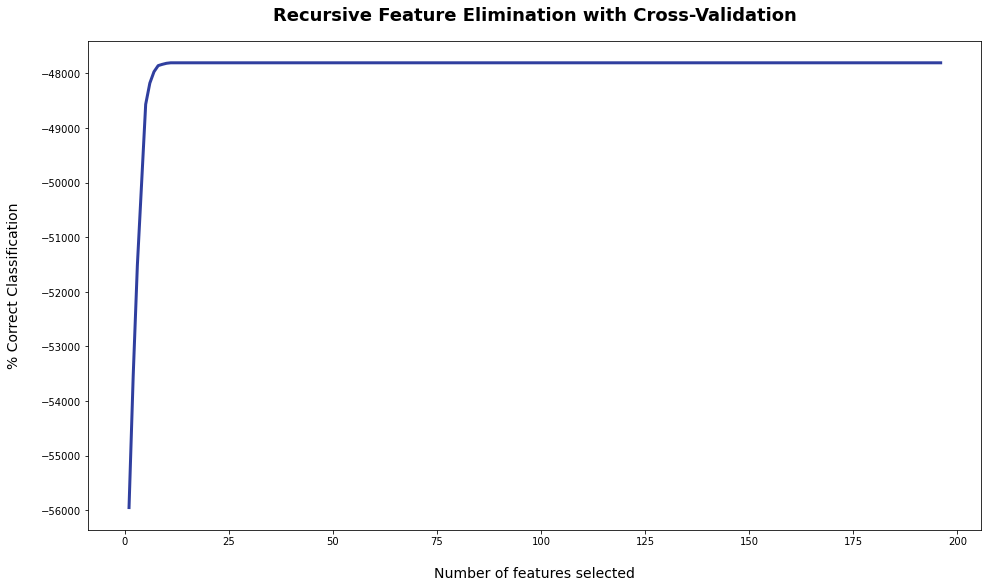

In [89]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

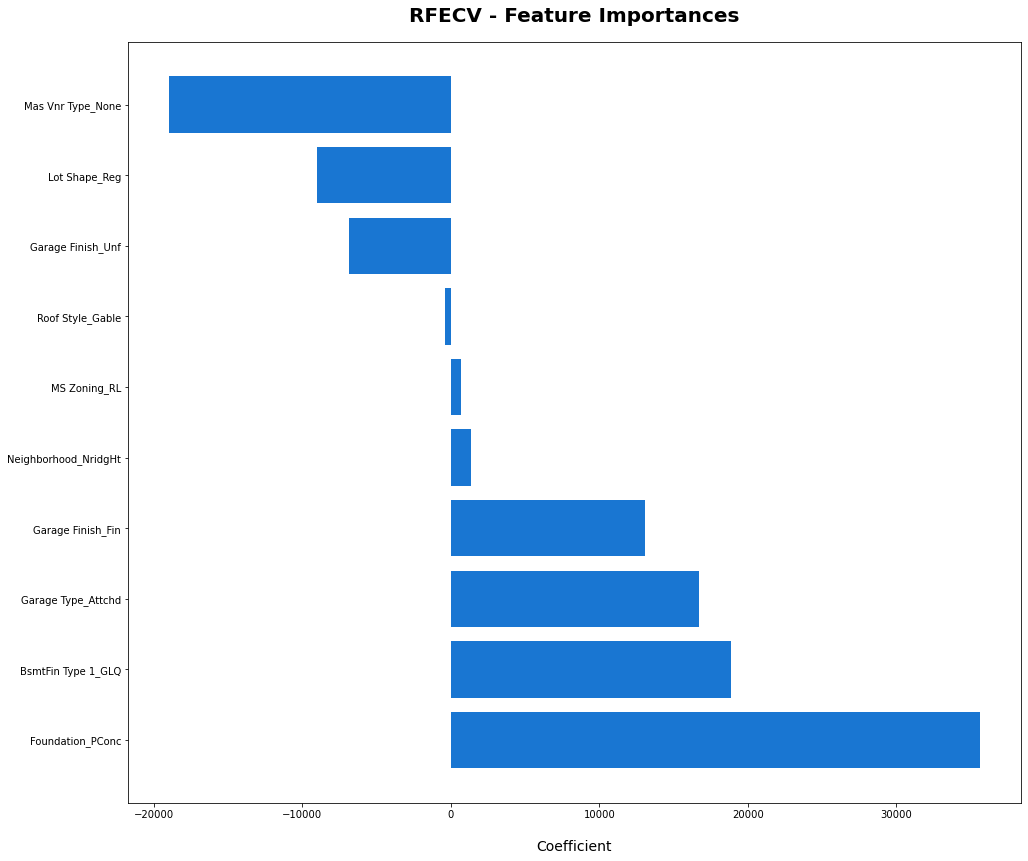

In [98]:
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset[dset['importance'] != 0]['attr'], width=dset[dset['importance'] != 0]['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Coefficient', fontsize=14, labelpad=20)
plt.show()

In [167]:
cat_col = set(dset[dset['importance'] != 0]['attr'].map(lambda x: x.split('_')[0]).unique().tolist())
cat_col.union({'Bldg Type',
 'Foundation',
 'Street',
 'Central Air',
 'Electrical',
 'MS Zoning',
 'Land Contour',
 'Mas Vnr Type',
 'Heating',
 'Paved Drive',
 'Neighborhood'
          });

### Let's try with our model

In [213]:
train = pd.read_csv('../datasets/train.csv')
train = cleaning_data(train)
train = feat_eng(train)
train = cat2num(train)
X_train = prep_poly(train,train)
y_train = train['SalePrice']

In [214]:
test = pd.read_csv('../datasets/test.csv')
test = cleaning_data(test)
test = feat_eng(test)
test = cat2num(test)
X_test = prep_poly(test,train)

In [ ]:
#load pre-trained model

# ridge = load('ridge_regressor.joblib')
# lasso = load('lasso_regressor.joblib')
# enet = load('enet_regressor.joblib')



#Elasticnet LR
l1_ratio = np.linspace(0, 1, 11)
l_alphas = np.arange(0.001, 1, 0.01)
enet_cv = ElasticNetCV(alphas=l_alphas, l1_ratio=l1_ratio, max_iter=5000,cv=5)
enet_cv.fit(X_train,y_train)

enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, max_iter=100000, warm_start=True)
#fit
enet.fit(X_train,y_train)


In [ ]:
#RMSE on training set
print('ElasticNet Regression')
print(metrics.mean_squared_error(y_train,enet.predict(X_train),squared = False),'\n')

In [ ]:
#Cross Validation RMSE

enet_cv_score = cross_val_score(
    enet, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1

#Cross Validation RMSE
print('ElasticNet Regression')
print(enet_cv_score,'\n')

Again, our ElasticNet model is taking the lead. I decided to finish fine tuning at this point.

### Making prediction and submit the result!

In [ ]:
Poly_RFEonCat_prediction = enet.predict(X_test)
Poly_RFEonCat_submission = pd.DataFrame(Poly_RFEonCat_prediction,
                                   index=test.Id,
                                   columns=['SalePrice'])
Poly_RFEonCat_submission.to_csv('../Submission/Poly_RFEonCat_submission.csv')

## Model Evaluation

So far, we've experimented with different model and subset of features, here is a quick comparison of the result

|                                  Model                                  | RMSE on Training set | Cross val RMSE |
|:-----------------------------------------------------------------------:|:--------------------:|:--------------:|
| **Baseline**                                                               | 79229.31             | 79229.31       |
| **Hand-selected features**                                                  |                      |                |
| Linear Regression                                                       | 30873.96             | 1.12 e17       |
| Ridge Regression                                                        | 31040                | 32141.44       |
| Lasso Regression                                                        | 30860                | 32422.76       |
| ElasticNet Regression                                                   | 31064                | 32136.14       |
| **Polynomial of numerical features**                                        |                      |                |
| Linear Regression                                                       | 18987.03             | 29875.408      |
| Ridge Regression                                                        | 19774.57             | 28527.88       |
| Lasso Regression                                                        | 19026.74             | 29812.54       |
| ElasticNet Regression                                                   | 19881.52             | 28528.27       |
| **Polynomial of numerical features + addition categorical features by RFE** |                      |                |
| ElasticNet Regression                                                   | 19881.52             | 28528.27       |

- All of our model significantly surpassed the performance of baseline model (except multiple linear regression).
- After introducing polynomial degree = 2 to numerical attriubtes, the training error greatly reduce. The same trend was also be observed in cross validation RMSE. However it's a clear sign of overfitting, since the gap between training and cross validation RMSE is very huge.
- I selected an ElasticNet model as a candidate for further improvement, therefore the rest of intepretion will be based on ElasticNet regressor.


https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15